In [1]:
!pip install einops
!pip install mmcv==1.2.7
!pip -q install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.2/231.2 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv: filename=mmcv-1.2.7-py2.py3-none-any.whl size=336527 sha256=ceacc91ae49ea81f17a699d223498c2fd428ef255e83a53cec6fe7c0d6eb1669
  Stored in directory: /root/.cache/pip/wheels/92/36/f6/0cf509e522e9874de6b9e1dbded025550756caaca4b9fccf1b
Successfully built mmcv


In [3]:

import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
import os
import cv2
from tqdm import tqdm
import torch.utils.checkpoint as checkpoint
import numpy as np
from timm.models.layers import DropPath, trunc_normal_
from functools import reduce, lru_cache
from operator import mul
from einops import rearrange
from torch.optim import lr_scheduler
import logging
from mmcv.utils import get_logger
from mmcv.runner import load_checkpoint
import json
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face


In [5]:
CFG = {
    'vectorize': False,
    'extract_face': False,
    'extract_keypoints': True,
    'batch_size': 60,
    'show_examples': False,
    'n_frames': 3,
    'face_shape': (224,224),
}

(224, 224, 3)


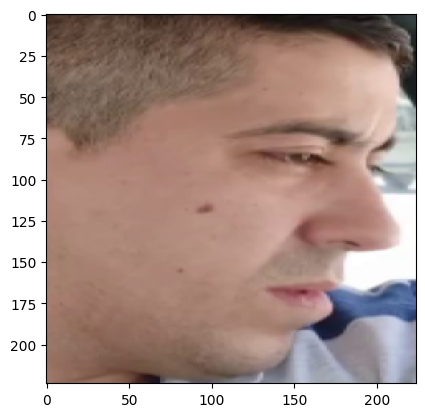

In [47]:
class FastMTCNN(object):
    """Fast MTCNN implementation."""
    
    def __init__(self, stride, resize=1, *args, **kwargs):
        """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
        """
        self.stride = stride
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)
        
    def __call__(self, frames):
        """Detect faces in frames using strided MTCNN."""
        if self.resize != 1:
            frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]
    
        boxes, probs = self.mtcnn.detect(frames)

        faces = []
        
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            for box in boxes[box_ind]:
                box = [int(b) for b in box]
                face = frame[box[1]:box[3], box[0]:box[2]]
                try:
                    faces.append(cv2.resize(face, CFG['face_shape'], interpolation = cv2.INTER_AREA))
                except:
                    continue
        
        return faces
fast_mtcnn = FastMTCNN(
    stride=4,
    resize=0.5,
    margin=14,
    factor=0.2,
    keep_all=True,
    device='cuda'
)
video_path = '/kaggle/input/sust-ddd/SUST Driver Drowsiness Dataset/drowsiness/d_1.mp4'
video = cv2.VideoCapture(video_path)
ret,frame = video.read()
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
face = fast_mtcnn(frame[None,:])
print(face[0].shape)
plt.imshow(face[0])


In [46]:
video_path = '/kaggle/input/sust-ddd/SUST Driver Drowsiness Dataset/drowsiness/d_1.mp4'
video = cv2.VideoCapture(video_path)
ret,frame = video.read()
fast_mtcnn(frame[None,:])

[]

In [50]:
class MetaDataSet(Dataset):
    def __init__(self,meta_data,root,train = True,detect_face = False):
        super().__init__()
        
        with open(meta_data,'r') as f:
            meta_data = json.load(f)
        if train:
            del meta_data['fold1']
            self.data = meta_data
        else:
            self.data = {}
            self.data['fold1'] = meta_data['fold1']
            
        self.detect_face = detect_face    
        self.input_file = []
        self.root = root
        self.detector = None
        for _,val in self.data.items():
            self.input_file.extend(val['active'])
            self.input_file.extend(val['drowsiness'])
        if not self.detect_face:
            self.transform = transforms.Compose([
                                transforms.Resize(size = (224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])
        else:
            self.detector = FastMTCNN(
                                stride=4,
                                resize=0.5,
                                margin=14,
                                factor=0.6,
                                keep_all=True,
                                device='cuda'
                            )
            self.transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])
        
        
    def __len__(self):
        return len(self.input_file)
    
    def __getitem__(self,index):
        video_name = self.input_file[index]
        if 'd' in video_name:
            video_path = os.path.join(os.path.join(self.root , 'drowsiness'),video_name)
        else:
            video_path = os.path.join(os.path.join(self.root , 'not drowsiness'),video_name)
    
        label = 0 if 'not drowsiness' in video_path else 1
        frames_list = []
        cap = cv2.VideoCapture(video_path)
        start_time = time.time()
        fps = round(cap.get(cv2.CAP_PROP_FPS))
        curr_frame = 0 
        while cap.isOpened():
            ret,frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
 
            if curr_frame % fps == 0:
                frame = Image.fromarray(frame)
                frames_list.append(frame)
                start_time = time.time()
            curr_frame += 1
        
        frames_list = self.detector(np.stack(frames_list))
        frames_list = torch.stack([self.transform(f) for f in frames_list])
        
        return frames_list,label
    
def collate_fn(batch):
    label = [d[1] for d in batch]
    
    batch = [torch.concatenate([d,torch.zeros(10-d.shape[0],d.shape[1],d.shape[2],d.shape[3])],dim=0)
                        if d.shape[0] < 10 else d[:10] for d,label in batch]

    return torch.stack(batch),torch.tensor(label)
NUM_WORKERS = os.cpu_count()

metadata_path = '/kaggle/input/metadata/dataset_metadata.json'
root_path = '/kaggle/input/sust-ddd/SUST Driver Drowsiness Dataset'

train_data = MetaDataSet(metadata_path,root_path,train = True,detect_face = True)
test_data = MetaDataSet(metadata_path,root_path, train = False,detect_face = True)

train_loader = DataLoader(train_data,batch_size = 16,shuffle = True,num_workers=NUM_WORKERS,collate_fn=collate_fn)
test_loader = DataLoader(test_data,batch_size = 16,shuffle = True,num_workers=NUM_WORKERS,collate_fn = collate_fn)


In [51]:
class LastLayer(nn.Module):
    def __init__(self,in_feature,hidden_feature,output_feature,num_layers):
        super(LastLayer, self).__init__()
        self.ln1 = nn.Linear(in_feature,hidden_feature)
        self.bn = nn.BatchNorm1d(hidden_feature)
        self.ln2 = nn.ModuleList([nn.Linear(hidden_feature,hidden_feature) for _ in range(num_layers)])
        self.bn2 = nn.ModuleList([nn.BatchNorm1d(hidden_feature) for _ in range(num_layers)])

        self.ln3 = nn.Linear(hidden_feature,output_feature)
       
    def forward(self, x):
        x = F.relu(self.bn(self.ln1(x)))
        for ln,bn in zip(self.ln2,self.bn2):
             x = F.relu(bn(ln(x)))
        return self.ln3(x)

    